In [1]:
import arviz as az
import numpy as np  # For vectorized math operations

import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r

from matplotlib import pyplot as plt
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format='retina'

sns.set_theme(
    context="notebook",
    style="white",
    font="Latin Modern Roman",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "text.usetex": True,
    },
)

extra_params = {
    "text.latex.preamble": " ".join([r"\usepackage{mathtools}", r"\usepackage{amssymb}"])
}

plt.rcParams.update(extra_params)

In [42]:
from pytensor.printing import Print

In [47]:
def make_data():
    np.random.seed(42)
    beta = np.random.normal(0, 1, (5, 1))
    x = np.random.normal(0, 1, (20, 5))
    y = x @ beta + np.random.normal(0, 0.1, (20, 1))
    return {
        "x": x,
        "y": y,
        "beta": beta
    }

In [48]:
D = make_data()

In [55]:
observed_outcome = D["y"].flatten()
observed_indep = D["x"]

N = 20
K = 5


coords = {
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

In [59]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    sigma_y = pm.Exponential("sigma_y", 1)

    yhat = pm.math.sum(beta_p * observed_indep, axis=1)
    # beta_p_print = Print("beta_p")(beta_p)
    # yhat_print = Print("yhat")(yhat)
    y = pm.Normal("y_obs", yhat, sigma_y, observed=observed_outcome, dims="obs")

In [60]:
with model_1:
    
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [beta_pf, mu_β_p, sigma_y, sigma_β_p, y_obs]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y_obs]


Output()

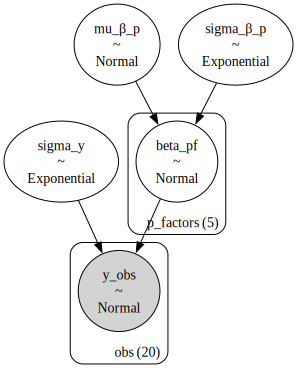

In [61]:
pm.model_to_graphviz(model_1)

In [62]:
az.summary(idata_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],0.489,0.031,0.429,0.547,0.001,0.000,3638.0,2238.0,1.0
beta_pf[pf_1],-0.160,0.028,-0.213,-0.107,0.000,0.000,4162.0,2868.0,1.0
beta_pf[pf_2],0.637,0.032,0.574,0.696,0.000,0.000,4413.0,2871.0,1.0
beta_pf[pf_3],1.521,0.029,1.468,1.575,0.000,0.000,3474.0,2442.0,1.0
beta_pf[pf_4],-0.290,0.021,-0.330,-0.250,0.000,0.000,4359.0,3013.0,1.0
mu_β_p,0.384,0.373,-0.359,1.053,0.007,0.005,3258.0,2641.0,1.0
sigma_y,0.104,0.020,0.069,0.141,0.000,0.000,2799.0,2382.0,1.0
sigma_β_p,0.875,0.344,0.395,1.481,0.007,0.005,3316.0,2702.0,1.0


In [63]:
D["beta"]

array([[ 0.49671415],
       [-0.1382643 ],
       [ 0.64768854],
       [ 1.52302986],
       [-0.23415337]])

## Gumbel (continuous)

In [21]:
params = {"N": 400}

In [22]:
def make_data(params):
    N = params["N"]
    np.random.seed(42)
    mu = np.random.normal(0, 1)
    η = np.random.gumbel(mu, 1, N)
    return {
        "η": η,
        "latent_mu": mu
    }

In [23]:
D = make_data(params)

In [24]:
observed_outcome = D["η"]

N = observed_outcome.shape[0]

coords = {
    "obs": range(N),
}

In [25]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    y = pm.Gumbel("y_obs", mu_β_p, 1, observed=observed_outcome, dims="obs")

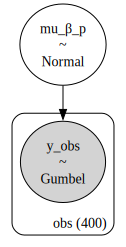

In [26]:
pm.model_to_graphviz(model_1)

In [27]:
with model_1:
    
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [mu_β_p, y_obs]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y_obs]


Output()

In [29]:
post["mu_β_p"]

<xarray.DataArray 'mu_β_p' (sample: 4000)> Size: 32kB
array([0.43173908, 0.46910971, 0.59355078, ..., 0.57318508, 0.55096666,
       0.48808686])
Coordinates:
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

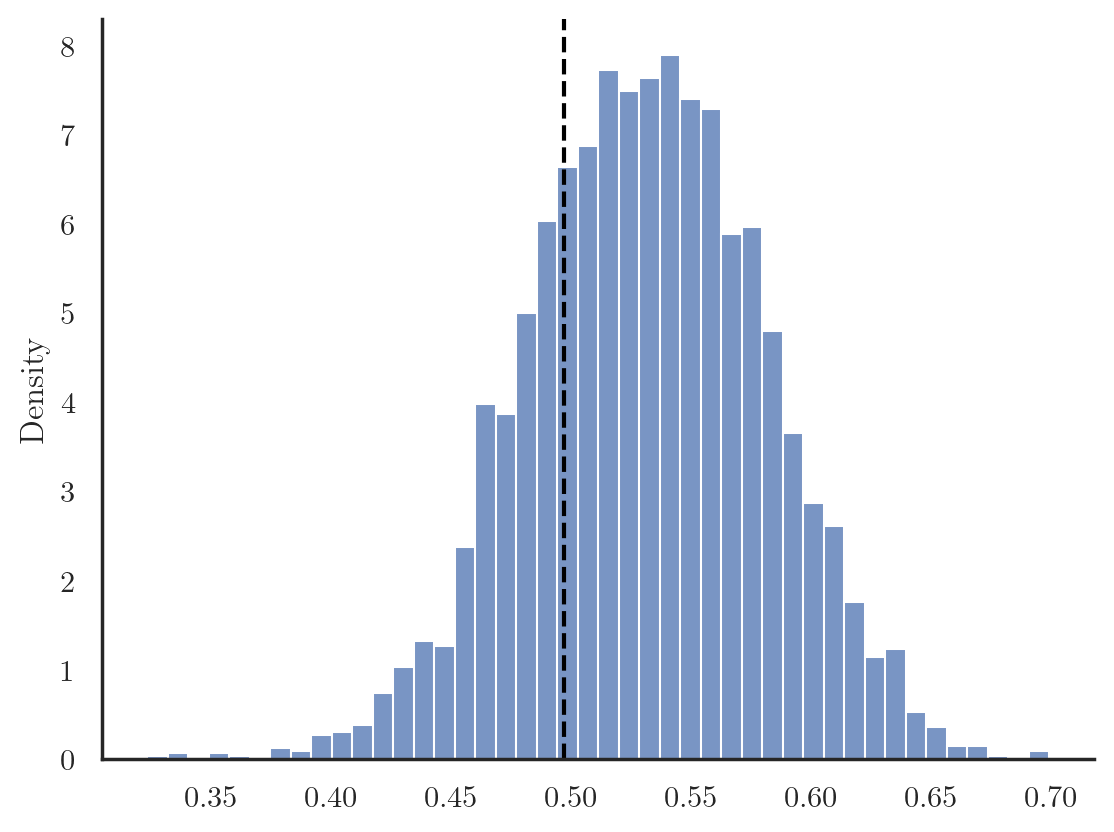

In [28]:
post = az.extract(idata_m1)

sns.histplot(post["mu_β_p"], stat="density")
plt.axvline(D["latent_mu"], linestyle="dashed", color="black")
plt.show()

# fig, axs = plt.subplots(3, 2)

# for i in range(6):
#     plt.sca(axs.flatten()[i])
#     if i >= K:
#         plt.gca().axis("off")
#         continue
#     sns.histplot(
#         post["beta_pf"][i, :],
#         bins=30,
#         ec="black",
#     )
#     plt.axvline(df["latent_β_prod"][0, i], linestyle="dashed", color="black")
#     plt.title(rf"$\beta_{i+1}$")
#     plt.ylabel(None)
#     plt.yticks([])

# plt.tight_layout()
# plt.show()

In [33]:
az.summary(idata_m1, var_names=["mu_β_p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_β_p,0.531,0.05,0.437,0.622,0.001,0.001,1188.0,1713.0,1.0


## Gumbel (categorical)

In [3]:
def make_data(params):
    N = params["N"]
    W = params["W"]
    np.random.seed(42)
    mu = np.random.normal(0, 1)
    η = np.random.gumbel(mu, 1, N)
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    w = np.digitize(gumbel_r.cdf(η), π)

    return {
        "w": w,
        "latent_η": η,
        "latent_mu": mu,
        "latent_cutpoints": π
    }

In [5]:
params = {
    "N": 100,
    "W": 3
}

D = make_data(params)

In [6]:
observed_outcome = D["w"] + 1

N = observed_outcome.shape[0]
W = observed_outcome.max()

coords = {
    "obs": range(N),
    "bins": range(W)
}

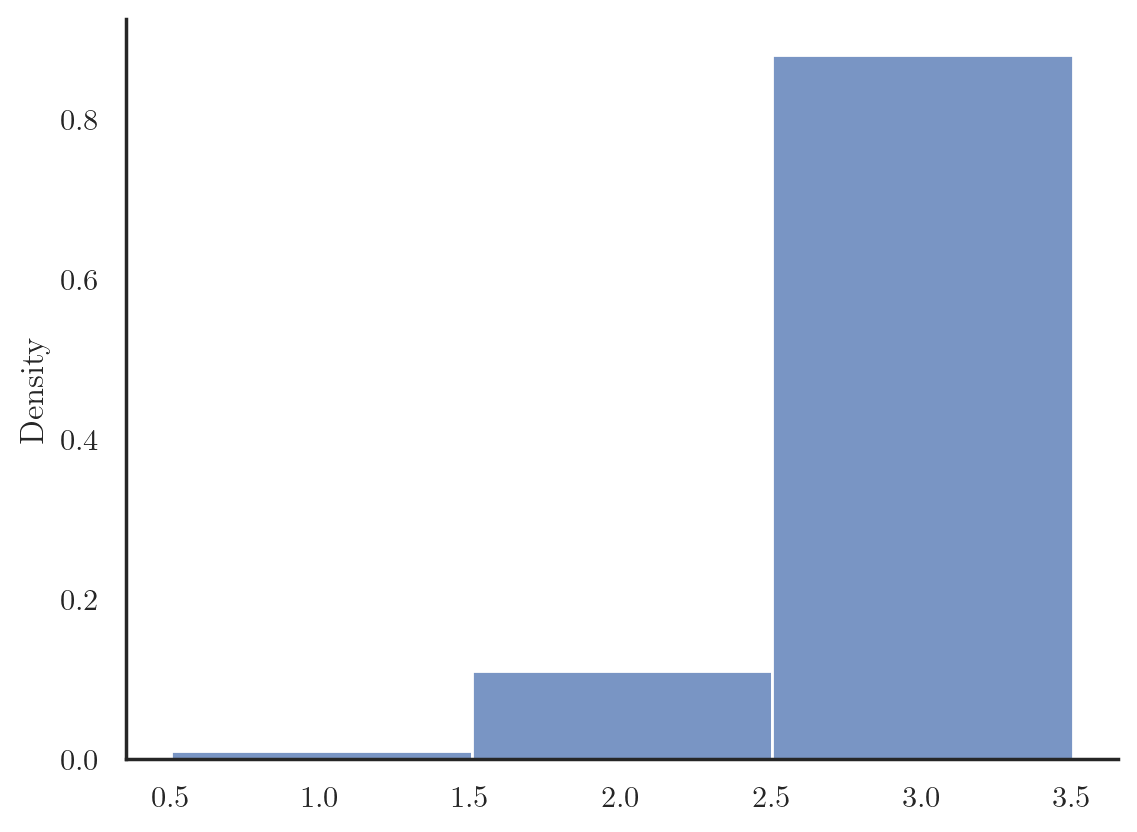

In [7]:
sns.histplot(observed_outcome, discrete=True, stat="density")
plt.show()

In [22]:
_, observed_counts = np.unique(observed_outcome, return_counts=True)

In [23]:
observed_counts

array([ 1, 11, 88])

In [24]:
D["latent_cutpoints"]

array([0.10878809, 0.31357818, 1.        ])

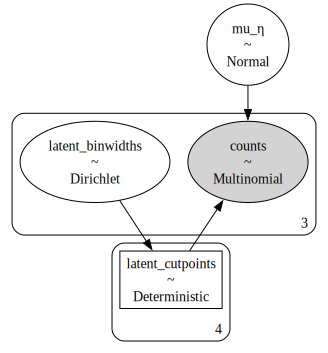

In [44]:
with pm.Model(coords=coords) as model_1:
    # based on https://www.pymc.io/projects/examples/en/latest/case_studies/binning.html
    mu = pm.Normal("mu_η", 0, 1)
    π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
    α = pm.Deterministic(
        "latent_cutpoints", pm.math.concatenate([np.ones(1) * 0, pm.math.cumsum(π)])
    )  # (W+1) x 1
    
    probs = pm.math.exp(pm.logcdf(pm.Gumbel.dist(mu, 1), α))
    probs = pt.extra_ops.diff(probs)
    # NOTE: it's not clear how this extends to the case where each observation has its own mean for the Gumbel
    likelihood = pm.Multinomial("counts", p=probs, n=sum(observed_counts), observed=observed_counts)

pm.model_to_graphviz(model_1)

In [45]:
with model_1:
    
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

post = az.extract(idata_m1)

Sampling: [counts, latent_binwidths, mu_η]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [counts]


Output()

In [51]:
D["latent_mu"]

0.4967141530112327

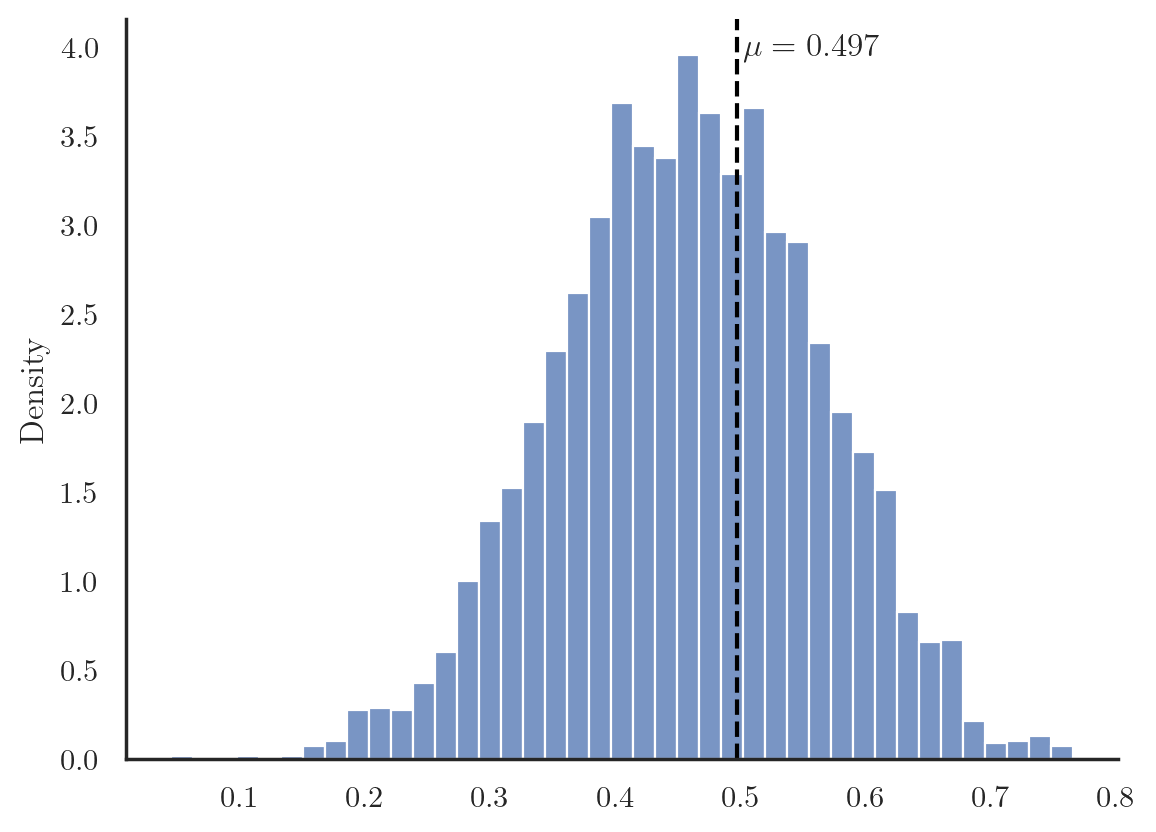

In [78]:
sns.histplot(post["mu_η"], stat="density")
plt.axvline(D["latent_mu"], linestyle="dashed", color="black")

trans = plt.gca().get_xaxis_transform()
plt.text(x=D["latent_mu"]*1.01, y=0.95, s=rf"$\mu={D['latent_mu']:.3f}$", transform=trans)
plt.show()

In [47]:
az.summary(idata_m1, var_names=["mu_η"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_η,0.458,0.103,0.268,0.649,0.002,0.002,1969.0,1872.0,1.0


In [79]:
np.around(np.diff(np.concatenate([np.zeros(1), D["latent_cutpoints"]])), 3)

array([0.109, 0.205, 0.686])

In [54]:
observed_counts/observed_counts.sum()

array([0.01, 0.11, 0.88])

In [52]:
az.summary(idata_m1, var_names=["latent_cutpoints"])

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
latent_cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.0,4000.0,4000.0,NaN
latent_cutpoints[1],0.021,0.014,0.001,0.047,0.000,0.0,1641.0,1245.0,1.0
latent_cutpoints[2],0.142,0.035,0.084,0.211,0.001,0.0,4597.0,3271.0,1.0
latent_cutpoints[3],1.000,0.000,1.000,1.000,0.000,0.0,3852.0,3808.0,1.0


### Ordered Logistic Regression

In [147]:
def make_data(params):
    N = params["N"]
    W = params["W"]
    np.random.seed(42)
    
    β = np.random.normal(size=1)
    π = np.random.dirichlet([1] * W, 1).flatten().cumsum()
    
    X = np.random.normal(size=(N, 1))
    # X = np.concatenate([np.ones_like(X), X], axis=1)
    η = np.random.logistic(0, 1, N)
    v = (X @ β + η).flatten()
    
    w = np.digitize(gumbel_r.cdf(v), π)
    # w = np.digitize((1+np.exp(-v))**-1, π)

    return {
        "w": pd.Categorical(w, categories = list(range(W)), ordered=True),
        "x": X,
        "latent_η": η,
        "latent_β": β,
        "latent_cutpoints": π
    }

In [148]:
params = {
    "N": 999,
    "W": 3
}

D = make_data(params)

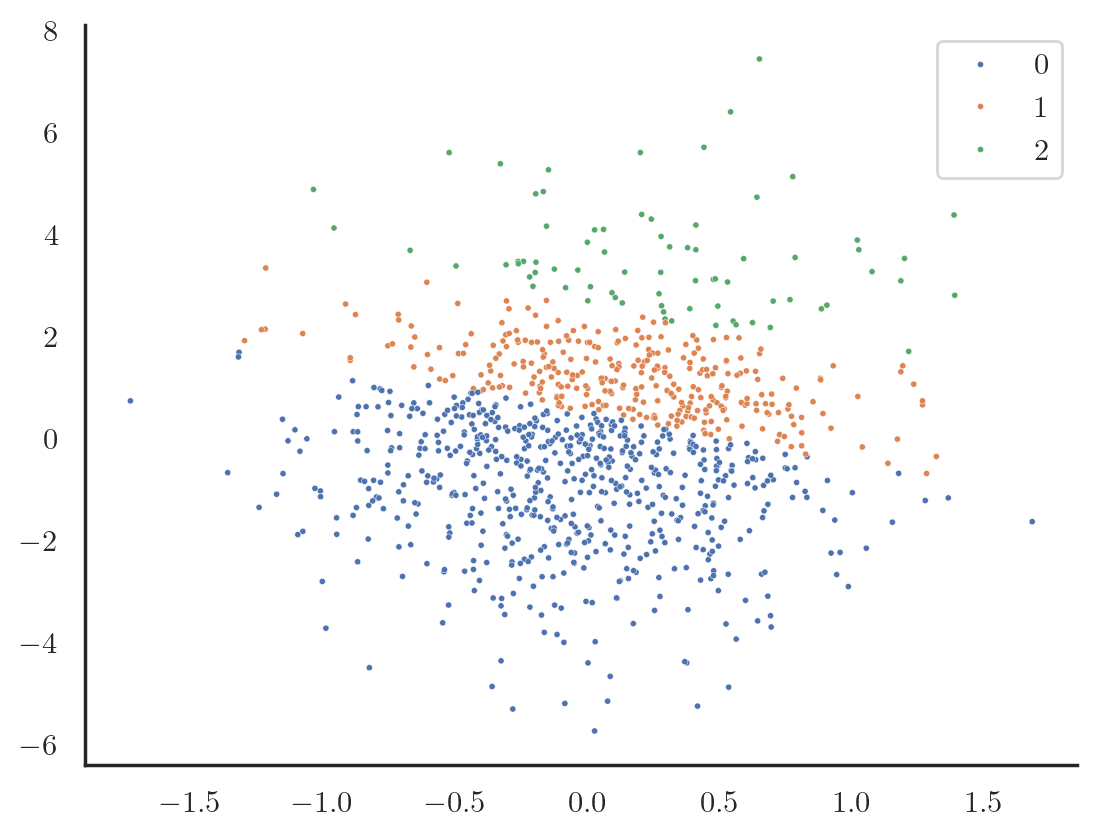

In [149]:
sns.scatterplot(x=(D["x"] @ D["latent_β"]), y=D["latent_η"], hue=D["w"], s=5)
plt.show()

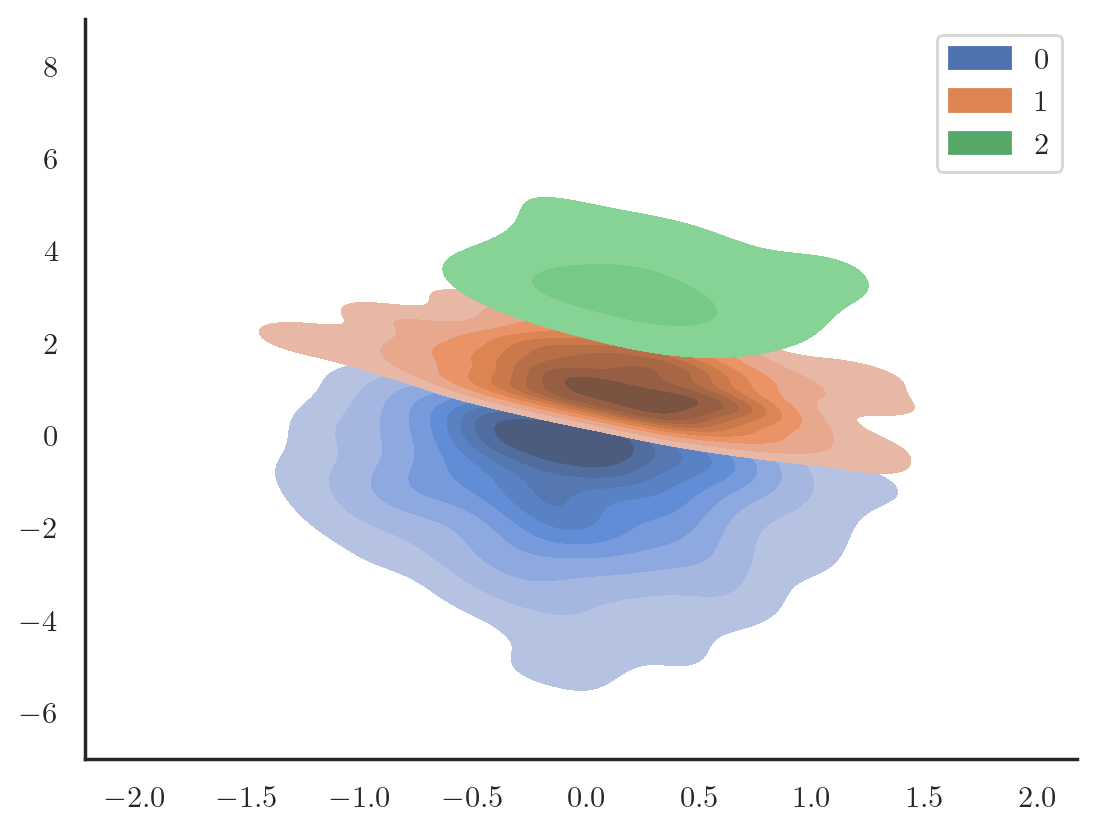

In [150]:
sns.kdeplot(x=(D["x"] @ D["latent_β"]), y=D["latent_η"], hue=D["w"], fill=True)
plt.show()

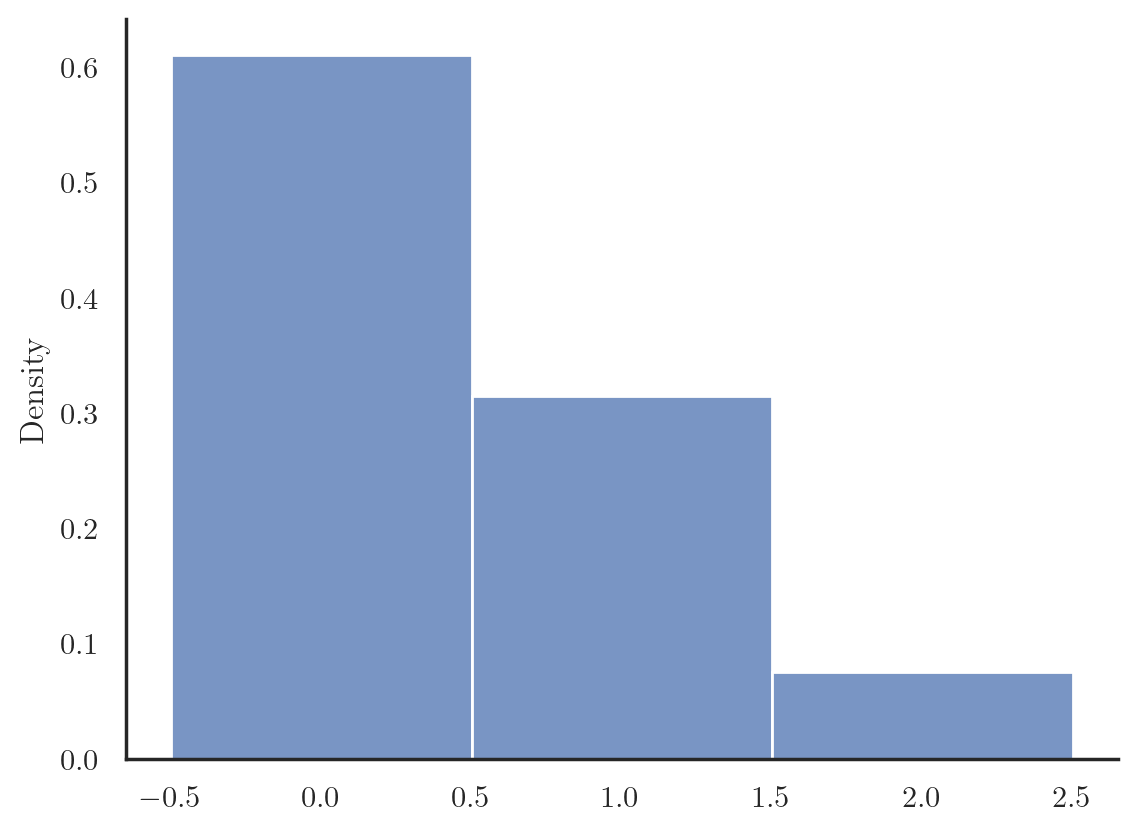

In [151]:
sns.histplot(D["w"], stat="density")
plt.show()

In [152]:
observed_outcome = D["w"]
observed_indep = D["x"]

N = observed_outcome.shape[0]
W = observed_outcome.max() + 1

coords = {
    "obs": range(N),
    "bins": range(W)
}

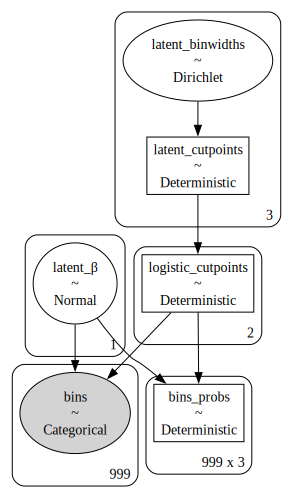

In [153]:
with pm.Model(coords=coords) as model_1:
    β = pm.Normal("latent_β", size=1)
    
    π = pm.Dirichlet("latent_binwidths", a=pm.math.ones(W))  # W x 1
    π = pm.Deterministic(
        "latent_cutpoints", pm.math.cumsum(π)
    )
    cutpoints = pm.Deterministic("logistic_cutpoints", -pm.math.log(-pm.math.log(π[:-1])))
    # cutpoints = pm.Deterministic("logistic_cutpoints", pm.math.log(π[:-1]) - pm.math.log(1-π[:-1]))
    
    likelihood = pm.OrderedLogistic("bins", eta=observed_indep @ β, cutpoints=cutpoints, observed=observed_outcome)

pm.model_to_graphviz(model_1)

In [154]:
with model_1:
    
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

post = az.extract(idata_m1)

Sampling: [bins, latent_binwidths, latent_β]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [bins]


Output()

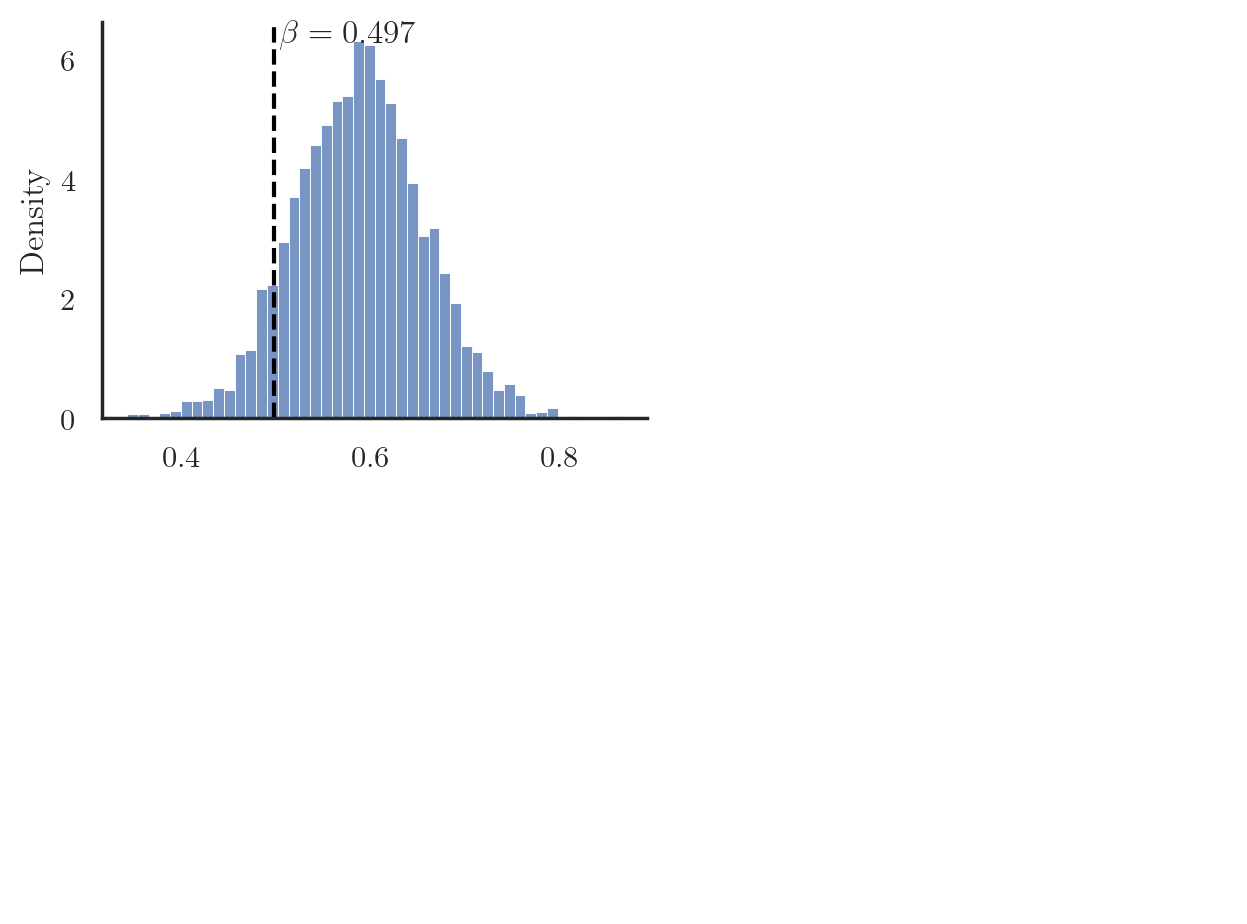

In [155]:
fig, axs = plt.subplots(2,2)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i < 1:
        sns.histplot(post["latent_β"][i, :], stat="density")
        dgp_value = D["latent_β"][i]
        plt.axvline(dgp_value, linestyle="dashed", color="black")
        trans = plt.gca().get_xaxis_transform()
        plt.text(x=dgp_value*1.01, y=0.95, s=rf"$\beta={dgp_value:.3f}$", transform=trans)
    else:
        plt.gca().axis('off')
plt.tight_layout()
plt.show()

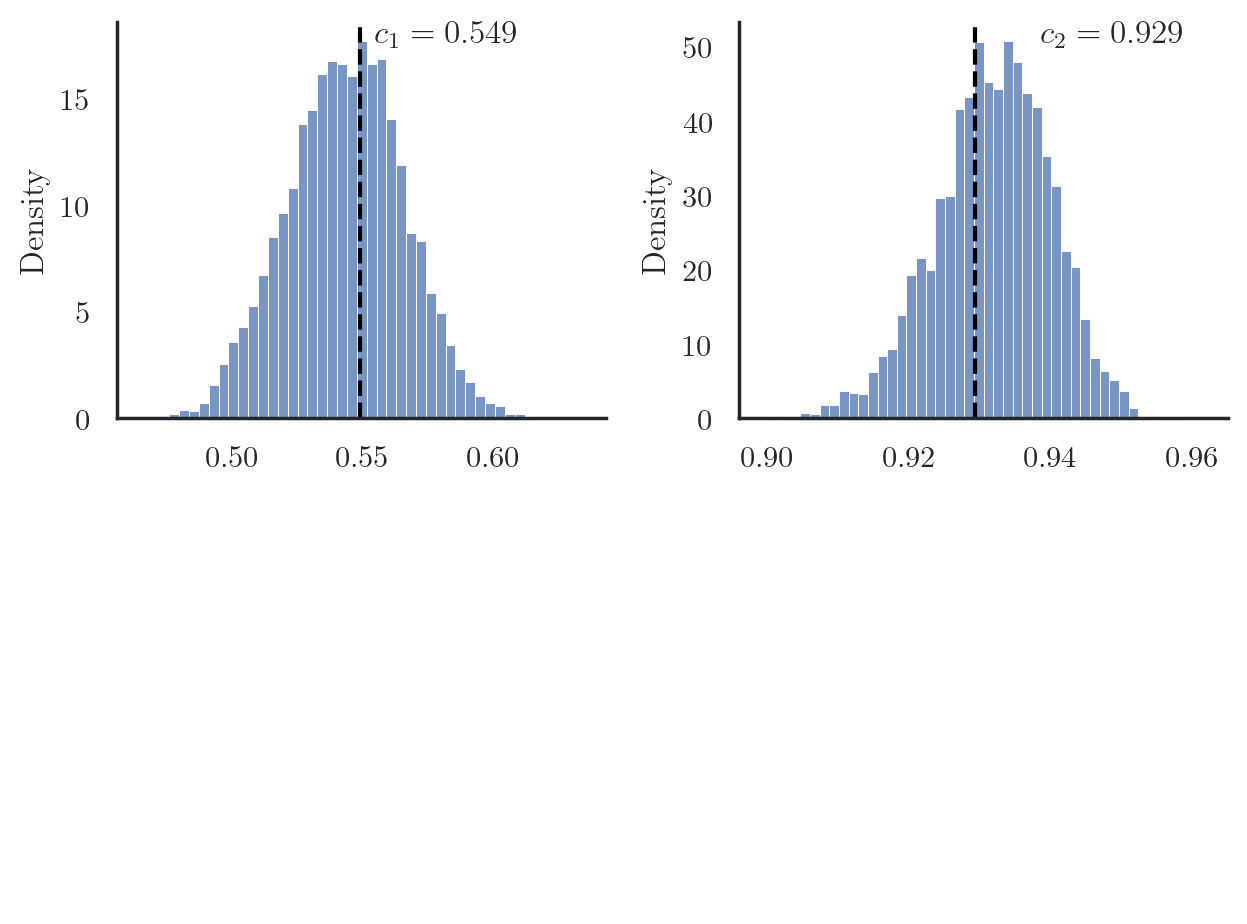

In [156]:
fig, axs = plt.subplots(2,2)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i < W-1:
        sns.histplot(post["latent_cutpoints"][i, :], stat="density")
        dgp_value = D["latent_cutpoints"][i]
        plt.axvline(dgp_value, linestyle="dashed", color="black")
        trans = plt.gca().get_xaxis_transform()
        plt.text(x=dgp_value*1.01, y=0.95, s=rf"$c_{i+1}={dgp_value:.3f}$", transform=trans)
    else:
        plt.gca().axis('off')
plt.tight_layout()
plt.show()

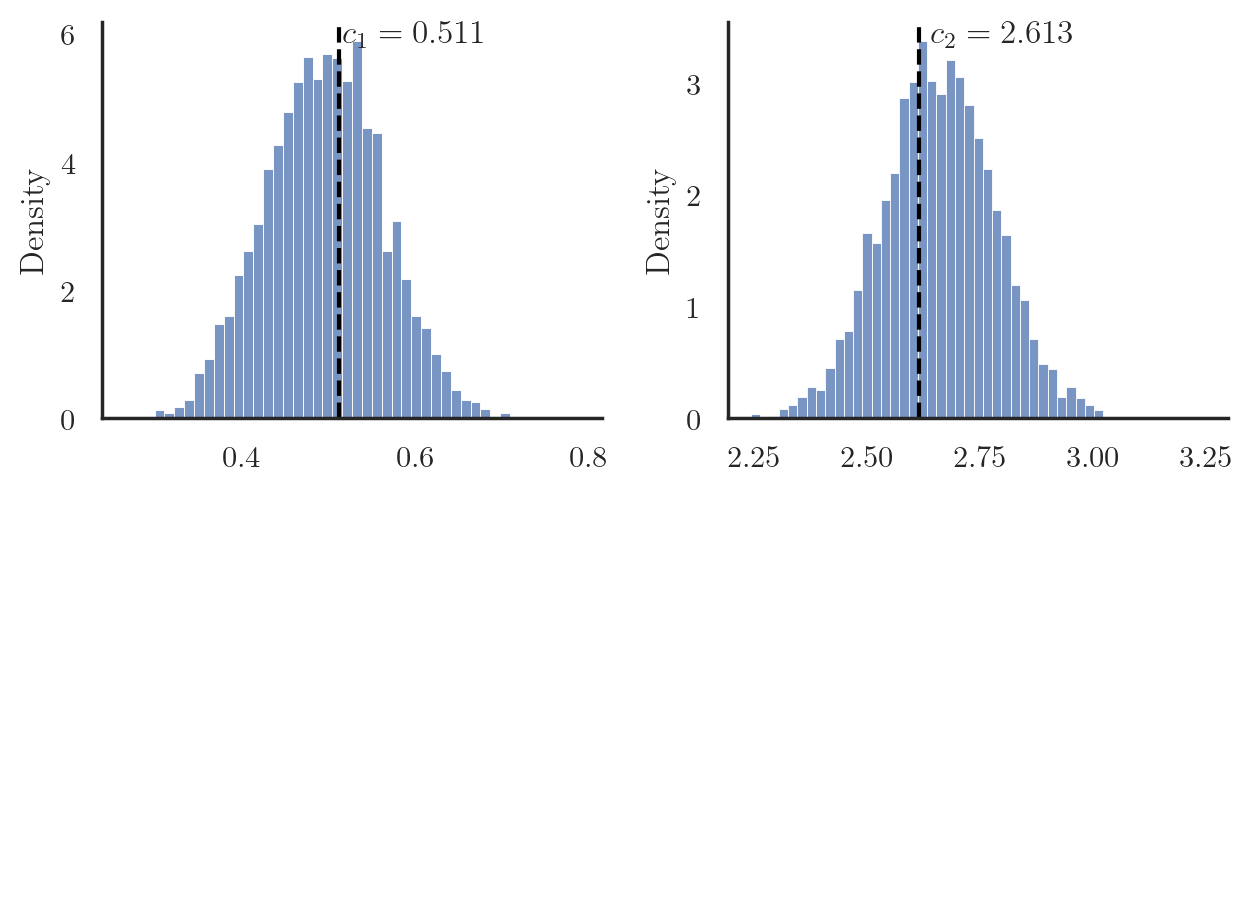

In [157]:
fig, axs = plt.subplots(2,2)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i < W-1:
        sns.histplot(post["logistic_cutpoints"][i, :], stat="density")
        dgp_value = gumbel_r.ppf(D["latent_cutpoints"][i])
        plt.axvline(dgp_value, linestyle="dashed", color="black")
        trans = plt.gca().get_xaxis_transform()
        plt.text(x=dgp_value*1.01, y=0.95, s=rf"$c_{i+1}={dgp_value:.3f}$", transform=trans)
    else:
        plt.gca().axis('off')
plt.tight_layout()
plt.show()

In [158]:
az.summary(idata_m1, var_names=["latent_β", "latent_cutpoints", "logistic_cutpoints"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
latent_β[0],0.587,0.069,0.458,0.716,0.001,0.001,3308.0,3018.0,1.0
latent_cutpoints[0],0.543,0.022,0.500,0.584,0.000,0.000,3256.0,2817.0,1.0
latent_cutpoints[1],0.932,0.008,0.916,0.947,0.000,0.000,3682.0,2754.0,1.0
latent_cutpoints[2],1.000,0.000,1.000,1.000,0.000,0.000,3931.0,3988.0,1.0
logistic_cutpoints[0],0.495,0.067,0.367,0.619,0.001,0.001,3256.0,2817.0,1.0
logistic_cutpoints[1],2.657,0.124,2.419,2.882,0.002,0.001,3682.0,2754.0,1.0


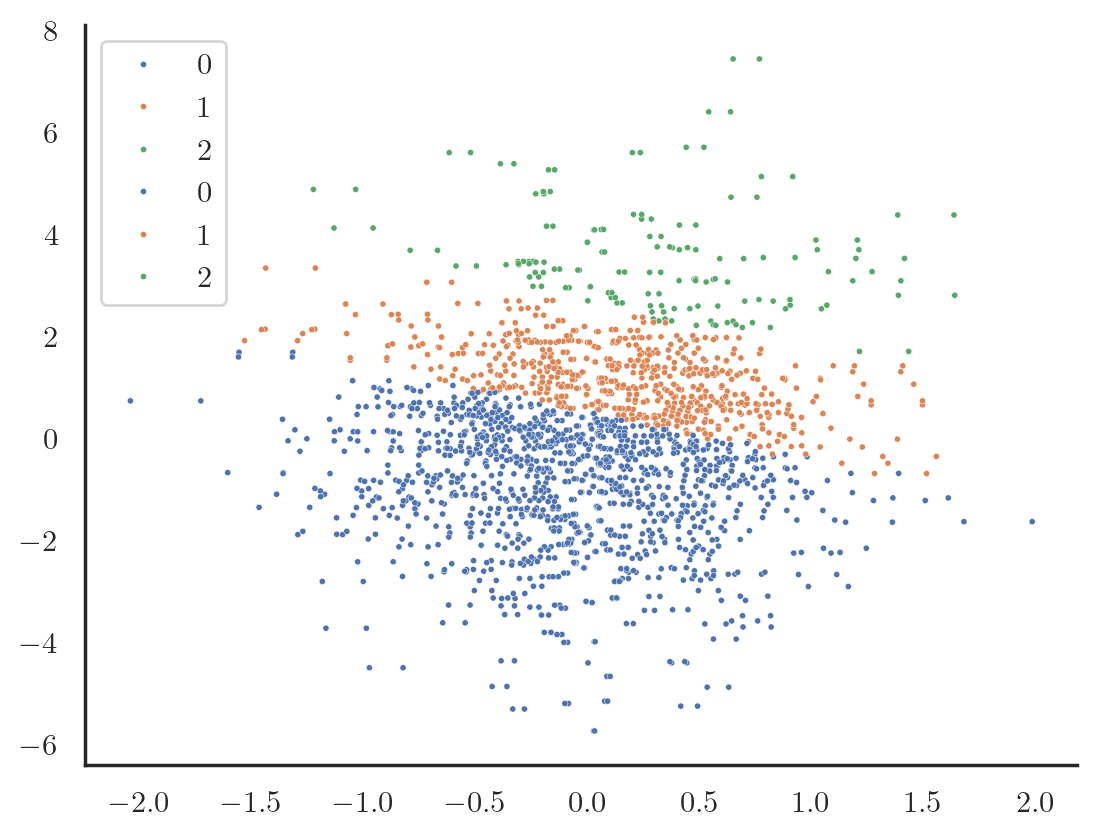

In [159]:
sns.scatterplot(x=(D["x"] @ D["latent_β"]), y=D["latent_η"], hue=D["w"], s=5)
sns.scatterplot(
    x=(D["x"] @ post["latent_β"].mean(axis=1).to_numpy()),
    y=D["latent_η"],
    hue=D["w"],
    s=5
)

plt.show()

### Compare to `statsmodels`

In [83]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [133]:
df = pd.DataFrame(D['x'], columns=['x1'])
df['w'] = D['w']

In [138]:
modf_logit = OrderedModel.from_formula(
    "w ~ x1", df, distr="logit"
)
resf_logit = modf_logit.fit(method="bfgs")
resf_logit.summary()
# statsmodels does a bad job of fitting the cutpoint

Optimization terminated successfully.
         Current function value: 0.880551
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      w   Log-Likelihood:                -8804.6
Model:                   OrderedModel   AIC:                         1.762e+04
Method:            Maximum Likelihood   BIC:                         1.764e+04
Date:                Thu, 22 Aug 2024                                         
Time:                        11:29:04                                         
No. Observations:                9999                                         
Df Residuals:                    9996                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4835      0.021     23.480      0.000       0.443       0.524
0/1            0.1522      0.021      7.393      0.000       0.112       0.193
1/2            0.8462      0.016     54.407      0.000       0.816       0.877
==============================================================================
"""

In [139]:
## Export to Stata to try
# df.to_stata("/Users/gzheng/Desktop/testdata.dta", version=None, write_index=False)

/var/folders/1g/5skf884x1xz2k279bv9_qyhm0000gn/T/ipykernel_94982/44495719.py:1: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column w contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  df.to_stata("/Users/gzheng/Desktop/testdata.dta", version=None)
